In [23]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU, use CPU
# gpus = tf.config.experimental.list_physical_devices("GPU")
# if gpus:
#     try:
#         tf.config.experimental.set_memory_growth(gpus[0], True)
#         print("✅ GPU Acceleration Enabled")
#     except RuntimeError as e:
#         print(e)
tf.config.set_visible_devices([], 'GPU')

In [24]:
################### Split train - test ###################

image_dir = "/Users/rfalcao/FYP/Idealised_Cusp_Exercise/idealised_cusps/images"
mask_dir = "/Users/rfalcao/FYP/Idealised_Cusp_Exercise/idealised_cusps/masks"

import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

IMG_SIZE = 224  # Input size for U-Net

# Get all image filenames
image_filenames = sorted(os.listdir(image_dir))  # Sort for consistency
mask_filenames = set(os.listdir(mask_dir))  # Convert to set for fast lookup


# Split filenames into train (80%) and unseen test set (20%)
train_filenames, test_filenames = train_test_split(image_filenames, test_size=0.1, random_state=42)

print(f"Training Set: {len(train_filenames)} images")
print(f"Unseen Test Set: {len(test_filenames)} images")


Training Set: 45 images
Unseen Test Set: 5 images


In [ ]:
################### Augment data ###################

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def augment_images(filenames, image_dir, mask_dir, num_augments_per_image=4):
    images, masks = [], []

    for filename in filenames:
        img_path = os.path.join(image_dir, filename)

       
        
        mask_path = os.path.join(mask_dir, filename) if filename in filenames else None
        
        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping {filename} (missing image)")
            continue

        # Normalize
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)

        # Load mask or create an empty one
        if mask_path and os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = mask.astype(np.float32) / 255.0
            mask = np.expand_dims(mask, axis=-1)
            
        else:
            mask = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.float32)
            

        # Apply augmentation multiple times
        for _ in range(num_augments_per_image):
            seed = np.random.randint(10000)
            aug_img = datagen.random_transform(img, seed=seed)
            aug_mask = datagen.random_transform(mask, seed=seed)

            # Resize after augmentation
            aug_img = cv2.resize(aug_img, (IMG_SIZE, IMG_SIZE))
            aug_mask = cv2.resize(aug_mask, (IMG_SIZE, IMG_SIZE))

            images.append(aug_img)
            masks.append(aug_mask)

    return np.array(images), np.array(masks)

# Load and augment only training images
augmented_X_train, augmented_y_train = augment_images(train_filenames, image_dir, mask_dir, num_augments_per_image=10)

print(f"Total Training Images After Augmentation: {len(augmented_X_train)}")
print(f"Total Training Masks After Augmentation: {len(augmented_y_train)}")

Total Training Images After Augmentation: 450
Total Training Masks After Augmentation: 450


In [29]:
################### Define Model ###################

NUM_CLASSES = 1
IMG_SIZE = 224  # Input size for U-Net
from metrics import log_dice_loss , dice_coef, iou

def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = Input(input_size)

    # Contracting path
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)

    # Expansive path
    up1 = UpSampling2D((2, 2))(conv3)
    concat1 = Concatenate()([up1, conv2])
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)

    up2 = UpSampling2D((2, 2))(conv4)
    concat2 = Concatenate()([up2, conv1])
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)

    # Final segmentation map
    output = Conv2D(NUM_CLASSES, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss=log_dice_loss, metrics=['binary_accuracy',dice_coef, iou])
    return model
# def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 1)):
#     inputs = Input(input_size)

#     # Contracting path (encoder)
#     conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     pool1 = MaxPooling2D((2, 2))(conv1)

#     conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
#     pool2 = MaxPooling2D((2, 2))(conv2)

#     conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
#     pool3 = MaxPooling2D((2, 2))(conv3)  # New down-sampling layer ✅

#     conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)  # New layer ✅
#     pool4 = MaxPooling2D((2, 2))(conv4)  # New down-sampling layer ✅

#     # Bottleneck
#     conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)  # Deepest layer ✅

#     # Expansive path (decoder)
#     up1 = UpSampling2D((2, 2))(conv5)
#     concat1 = Concatenate()([up1, conv4])
#     conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)  # New layer ✅

#     up2 = UpSampling2D((2, 2))(conv6)
#     concat2 = Concatenate()([up2, conv3])
#     conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)

#     up3 = UpSampling2D((2, 2))(conv7)
#     concat3 = Concatenate()([up3, conv2])
#     conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)

#     up4 = UpSampling2D((2, 2))(conv8)
#     concat4 = Concatenate()([up4, conv1])
#     conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)

#     # Final segmentation map
#     output = Conv2D(NUM_CLASSES, (1, 1), activation='sigmoid')(conv9)

#     model = Model(inputs, output)
#     model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['binary_accuracy', dice_coef, iou])
#     return model

# Create and train model
model = unet_model()
model.summary()




Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 224, 224,  │        640 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 112, 112,  │          0 │ conv2d_50[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_20… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 56, 56,    │          0 │ conv2d_51[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 56, 56,    │    295,168 │ max_pooling2d_21… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_20    │ (None, 112, 112,  │          0 │ conv2d_52[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 112, 112,  │          0 │ up_sampling2d_20… │
│ (Concatenate)       │ 384)              │            │ conv2d_51[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 112, 112,  │    442,496 │ concatenate_20[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_21    │ (None, 224, 224,  │          0 │ conv2d_53[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 224, 224,  │          0 │ up_sampling2d_21… │
│ (Concatenate)       │ 192)              │            │ conv2d_50[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 224, 224,  │    110,656 │ concatenate_21[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 224, 224,  │         65 │ conv2d_54[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 922,881 (3.52 MB)

 Trainable params: 922,881 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
################### Check for blank masks ###################

print("Checking dataset for blank masks...")
num_blank_masks = np.sum(np.all(augmented_y_train == 0, axis=(1,2)))  # Count fully blank masks
print(f"⚠️ Found {num_blank_masks} blank masks out of {len(augmented_y_train)} total.")

if num_blank_masks > 0:
    print(f"❌ Your dataset contains {num_blank_masks} fully blank masks! Consider removing or handling them.")


Checking dataset for blank masks...
⚠️ Found 0 blank masks out of 450 total.


In [36]:
print("Checking mask statistics...")
print("Min:", np.min(augmented_y_train))
print("Max:", np.max(augmented_y_train))
print("Mean:", np.mean(augmented_y_train))

# Count how many masks are all 1s
num_fully_white = np.sum(np.all(augmented_y_train == 1, axis=(1, 2)))
num_fully_black = np.sum(np.all(augmented_y_train == 0, axis=(1, 2)))
print(f"✅ Fully white masks: {num_fully_white}")
print(f"✅ Fully black masks: {num_fully_black}")

Checking mask statistics...
Min: 0.0
Max: 1.0
Mean: 0.08600509
✅ Fully white masks: 0
✅ Fully black masks: 0


In [31]:
################### Train model ###################

from tensorflow.keras.callbacks import EarlyStopping

# mixed_precision.set_global_policy('mixed_float16')
# ✅ Use Early Stopping for efficient training
early_stopping = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

# ✅ Train the model
history = model.fit(
    augmented_X_train, augmented_y_train,
    epochs=10,  
    batch_size=8,  # Increase batch size for better GPU utilization
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - binary_accuracy: 0.0913 - dice_coef: 0.1455 - iou: 0.0836 - loss: 1.9342 - val_binary_accuracy: 0.0960 - val_dice_coef: 0.1448 - val_iou: 0.0848 - val_loss: 1.9250
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - binary_accuracy: 0.0960 - dice_coef: 0.1449 - iou: 0.0847 - loss: 1.9385 - val_binary_accuracy: 0.1110 - val_dice_coef: 0.1461 - val_iou: 0.0858 - val_loss: 1.9161
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - binary_accuracy: 0.1205 - dice_coef: 0.1508 - iou: 0.0889 - loss: 1.8964 - val_binary_accuracy: 0.1507 - val_dice_coef: 0.1486 - val_iou: 0.0879 - val_loss: 1.8993
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - binary_accuracy: 0.3123 - dice_coef: 0.1572 - iou: 0.1578 - loss: 1.8586 - val_binary_accuracy: 0.9366 - val_dice_coef: 0.1543 - val_iou: 0.2950 - val_loss: 1.8615
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - binary_accuracy: 0.9417 - dice_coef: 0.1674 - iou: 0.3843 - loss: 1.7921 - val_

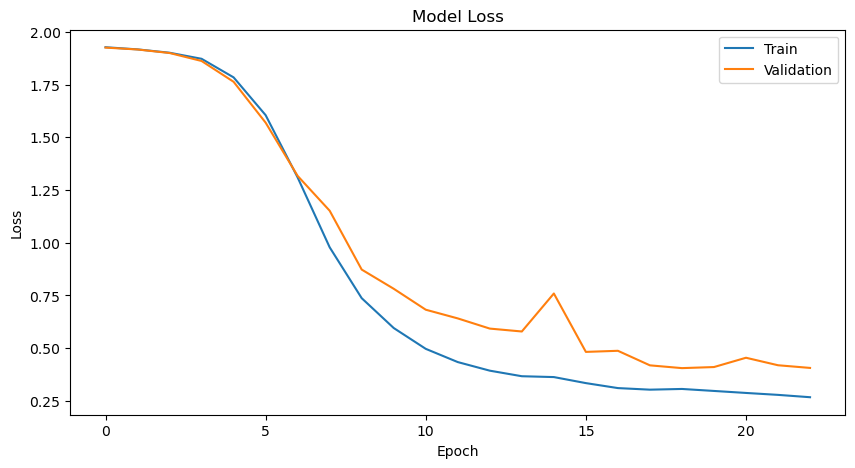

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [33]:
model.save('Idealised_Cusp_Unet.h5')

In [62]:
def load_test_images(filenames, image_dir, mask_dir):
    images, masks = [], []

    for filename in filenames:
        img_path = os.path.join(image_dir, filename)
        
        # ✅ Convert .jpg filename to .png for mask lookup
        mask_filename = os.path.splitext(filename)[0] + ".png"
        mask_path = os.path.join(mask_dir, mask_filename) if mask_filename in mask_filenames else None

        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping {filename} (missing image)")
            continue

        # Resize image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)

        # Load mask or create an empty one
        if mask_path and os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            mask = mask.astype(np.float32) / 255.0
            mask = np.expand_dims(mask, axis=-1)
        else:
            mask = np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load test images (no augmentation)
X_test, y_test = load_test_images(test_filenames, image_dir, mask_dir)

print(f"Final Test Set Size: {len(X_test)} images")

Final Test Set Size: 5 images


In [63]:
X_test=X_test[2:5]
y_test=y_test[2:5]

In [ ]:
def save_plot(image, true_mask, predicted_mask, save_dir, img_index):
    """Save the plot with original image, ground truth mask, and predicted mask."""
    os.makedirs(save_dir, exist_ok=True)  # Ensure the folder exists

    # Normalize predicted mask for better visualization
    predicted_mask_normalized = (predicted_mask - np.min(predicted_mask)) / (np.max(predicted_mask) - np.min(predicted_mask) + 1e-8)
    binary_mask = (predicted_mask > 0.5).astype(np.float32)  # Thresholded version

    # Create subplot
    plt.figure(figsize=(24, 6))

    # 🔹 Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    # 🔹 Ground Truth Mask
    plt.subplot(1, 4, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Actual Mask (Ground Truth)")
    plt.axis("off")

    # 🔹 Predicted Mask with Probability Legend
    plt.subplot(1, 4, 3)
    mask_plot = plt.imshow(predicted_mask_normalized, cmap='viridis')  # ✅ Normalize & use viridis
    plt.colorbar(mask_plot, fraction=0.046, pad=0.04)
    plt.title("Predicted Mask (Probability)")
    plt.axis("off")

    # 🔹 Binary Thresholded Mask
    plt.subplot(1, 4, 4)
    plt.imshow(binary_mask, cmap='gray')  # Show binary mask
    plt.title("Thresholded Prediction (Binary Mask)")
    plt.axis("off")

    # Save the figure
    save_path = os.path.join(save_dir, f"prediction_{img_index}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()  # Close the plot to free memory


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


In [49]:
test_pred = model.predict(X_test[:5])  # Predict first 5 test images

for i, pred in enumerate(test_pred):
    print(f"Test Image {i+1} - Min: {np.min(pred)}, Max: {np.max(pred)}, Mean: {np.mean(pred)}")
print(test_pred[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
Test Image 1 - Min: 0.0020594578236341476, Max: 0.9988349080085754, Mean: 0.21044375002384186
Test Image 2 - Min: 5.8264253311790526e-05, Max: 0.9686066508293152, Mean: 0.03546447679400444
Test Image 3 - Min: 0.00012239905481692404, Max: 0.9999644160270691, Mean: 0.12220877408981323
Test Image 4 - Min: 0.00014050422760192305, Max: 0.9999619126319885, Mean: 0.12585268914699554
Test Image 5 - Min: 0.00036345317494124174, Max: 0.9997192025184631, Mean: 0.12330440431833267
[[[0.12915932]
  [0.04136904]
  [0.0272531 ]
  ...
  [0.02862557]
  [0.04405122]
  [0.14018503]]

 [[0.04244   ]
  [0.00688184]
  [0.00422778]
  ...
  [0.00580083]
  [0.0100425 ]
  [0.06285804]]

 [[0.02849347]
  [0.00346516]
  [0.00204563]
  ...
  [0.00289845]
  [0.00493189]
  [0.04047641]]

 ...

 [[0.02038278]
  [0.00217836]
  [0.00116907]
  ...
  [0.00118359]
  [0.00232687]
  [0.02312494]]

 [[0.03161804]
  [0.00445888]
  [0.00270684]
  ...
  [0.00296736]
  [0.00522593]
  [0.040

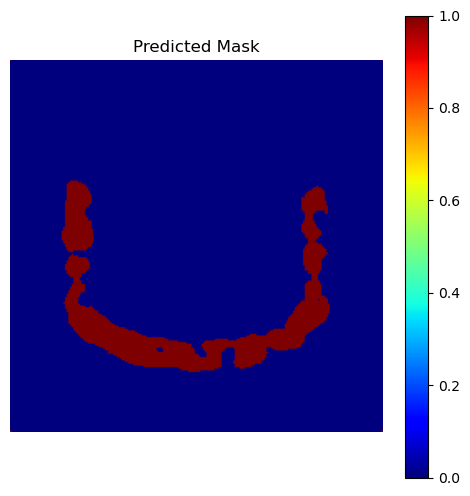

In [52]:
import matplotlib.pyplot as plt

# Select a specific prediction (e.g., first test image)
predicted_mask = test_pred[1].squeeze()>0.1  # Remove extra dimensions if needed

# Plot the predicted mask
plt.figure(figsize=(6, 6))
plt.imshow(predicted_mask, cmap='jet')  # Use 'jet' to visualize probabilities, or 'gray' for binary
plt.colorbar()  # Show probability legend
plt.title("Predicted Mask")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


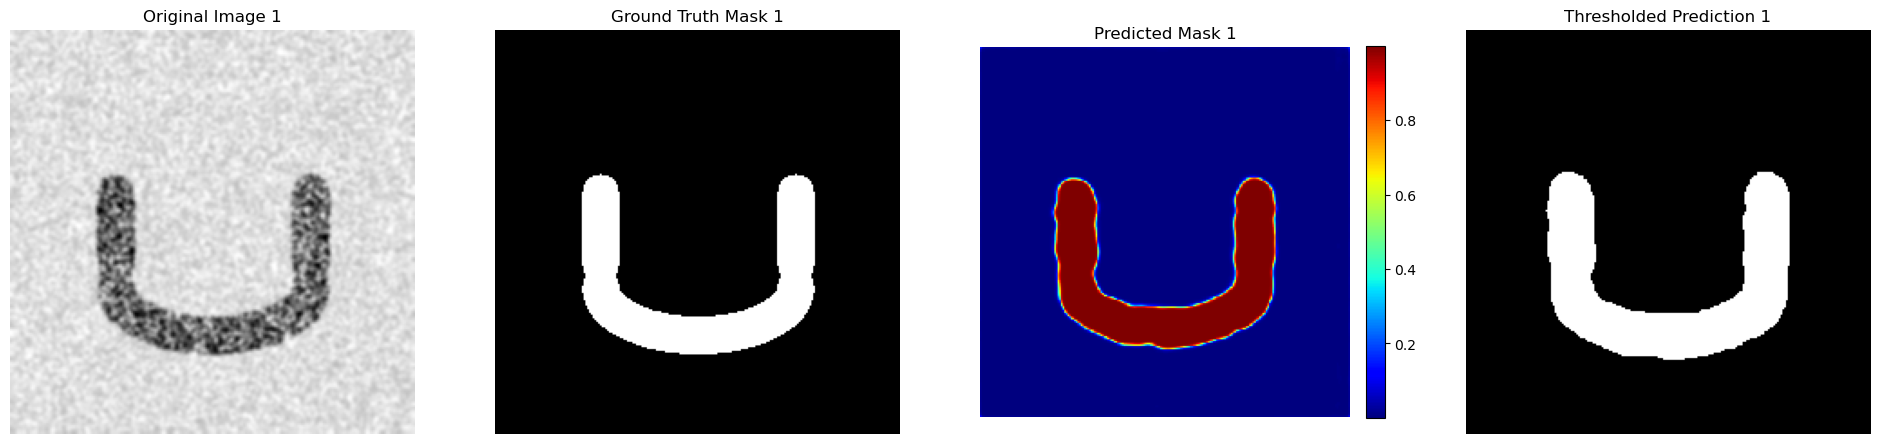

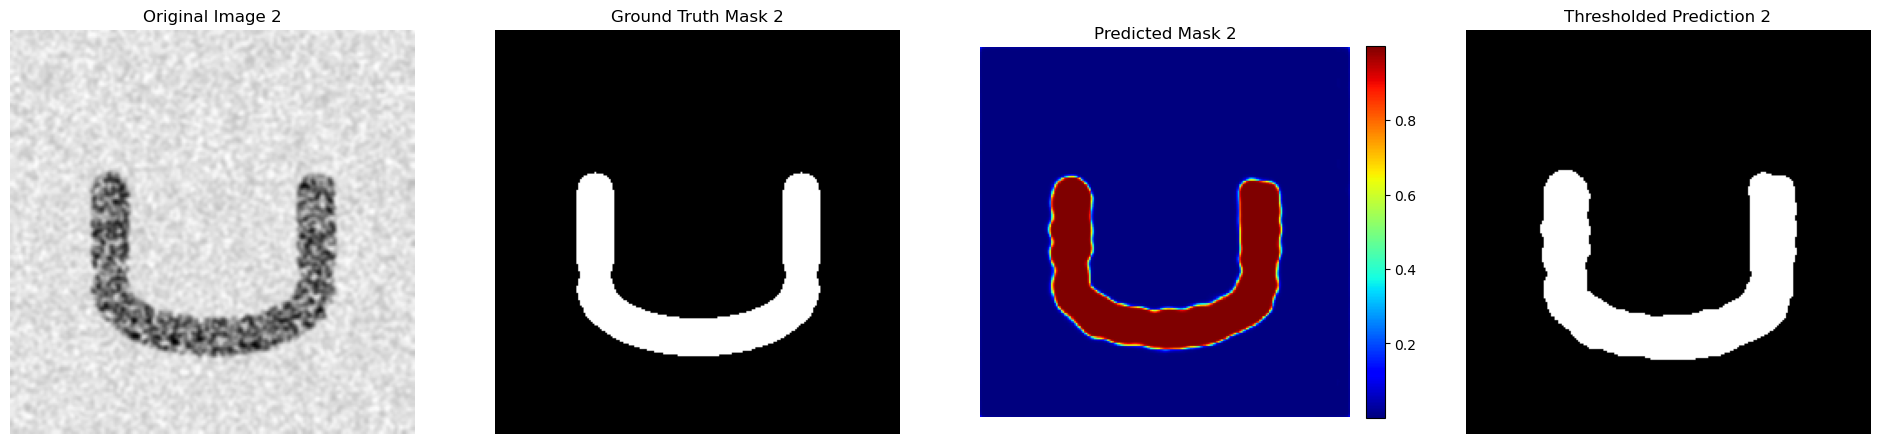

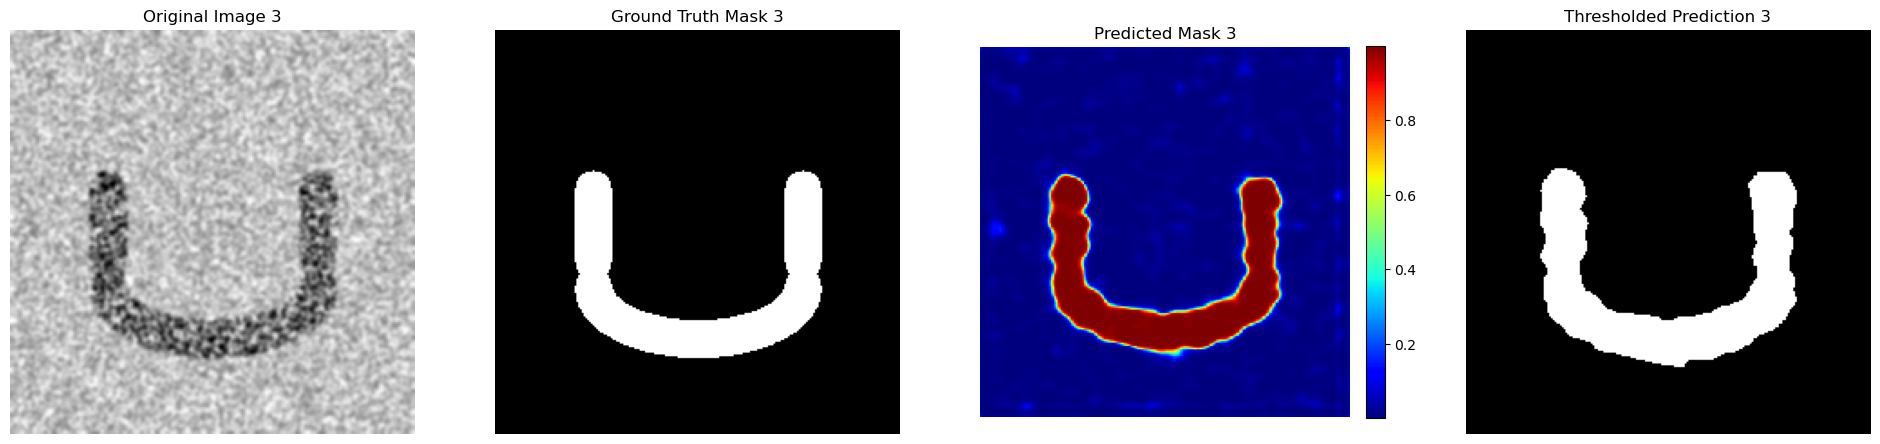

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_comparison(image, true_mask, predicted_mask, threshold=0.5, index=None):
    """
    Display the original image, ground truth mask, predicted mask, 
    and thresholded binary mask side by side.

    Args:
        image (numpy array): Original grayscale image.
        true_mask (numpy array): Ground truth binary mask.
        predicted_mask (numpy array): Model-predicted probability mask.
        threshold (float): Threshold to binarize the predicted mask.
        index (int, optional): Image index for display title.
    """
    # Apply threshold to predicted mask
    # binary_mask = (predicted_mask > threshold).astype(np.uint8)  # Convert probabilities to binary
    binary_mask = (predicted_mask > threshold)  # Convert probabilities to binary


    plt.figure(figsize=(24, 6))  # Create a wide figure

    # 🔹 Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original Image {index}" if index is not None else "Original Image")
    plt.axis("off")

    # 🔹 Ground Truth Mask
    plt.subplot(1, 4, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title(f"Ground Truth Mask {index}" if index is not None else "Ground Truth Mask")
    plt.axis("off")

    # 🔹 Predicted Mask (Probability Map)
    plt.subplot(1, 4, 3)
    mask_plot = plt.imshow(predicted_mask, cmap='jet')
    plt.colorbar(mask_plot, fraction=0.046, pad=0.04)  # ✅ Add probability legend
    plt.title(f"Predicted Mask {index}" if index is not None else "Predicted Mask")
    plt.axis("off")

    # 🔹 Thresholded Binary Mask
    plt.subplot(1, 4, 4)
    plt.imshow(binary_mask, cmap='gray')
    plt.title(f"Thresholded Prediction {index}" if index is not None else "Thresholded Prediction")
    plt.axis("off")

    plt.show()

test_pred = model.predict(X_test)  # Predict first 5 test images

for i in range(len(test_pred)):
    img = X_test[i].squeeze()  # Original image
    true_mask = y_test[i].squeeze()  # Ground truth mask
    predicted_mask = test_pred[i].squeeze()  # Model's predicted mask

    # Display the four images side by side
    plot_comparison(img, true_mask, predicted_mask, threshold=0.25, index=i+1)


✅ Test set augmented: 3 → 9 images
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ Saved: /Users/rfalcao/Documents/FYP/ManualSegmentationAnns/results/Idealised_plots/augmented_comparison_1.png


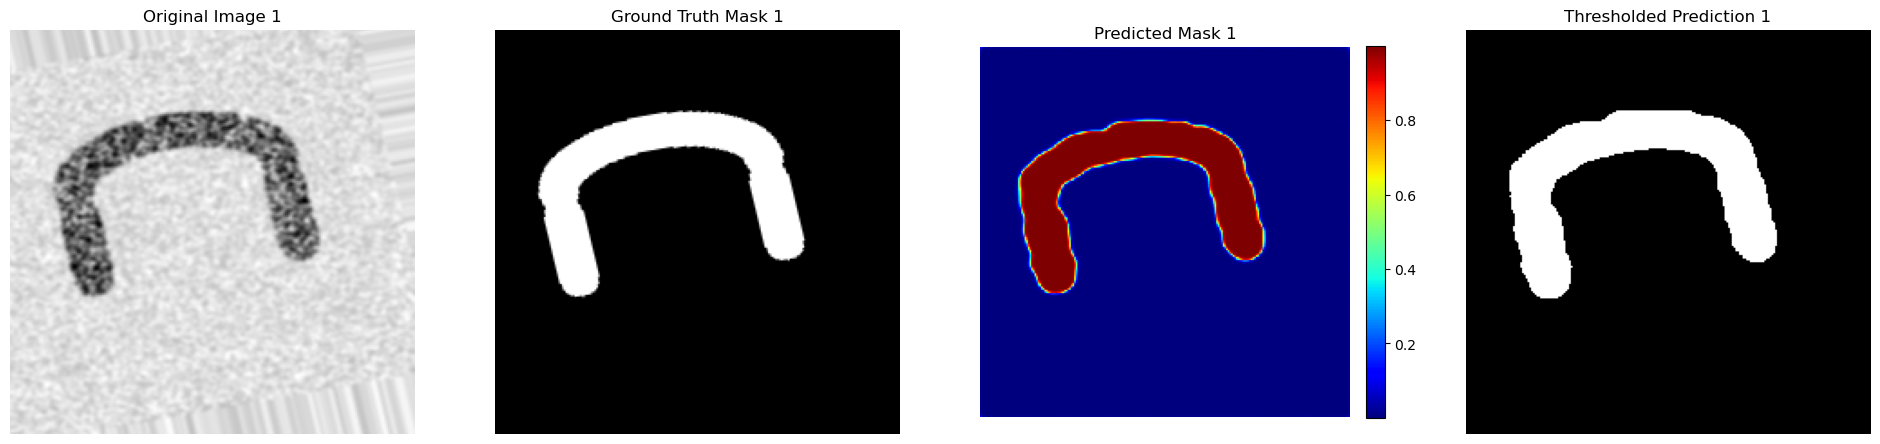

✅ Saved: /Users/rfalcao/Documents/FYP/ManualSegmentationAnns/results/Idealised_plots/augmented_comparison_2.png


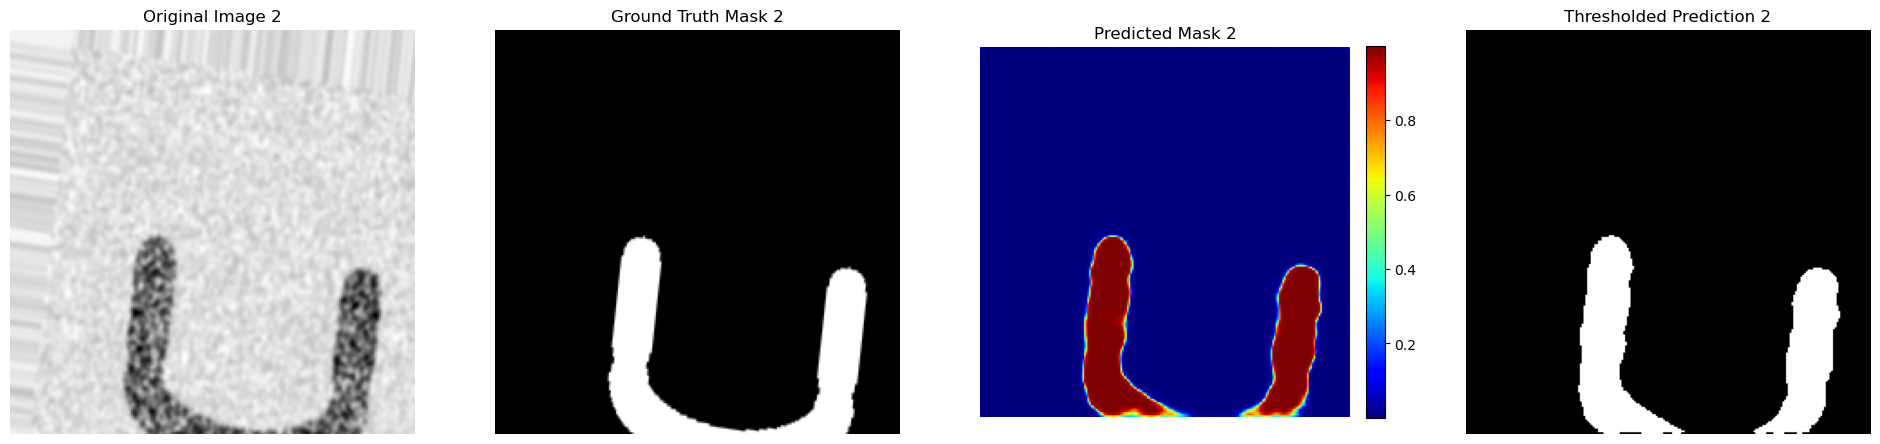

✅ Saved: /Users/rfalcao/Documents/FYP/ManualSegmentationAnns/results/Idealised_plots/augmented_comparison_3.png


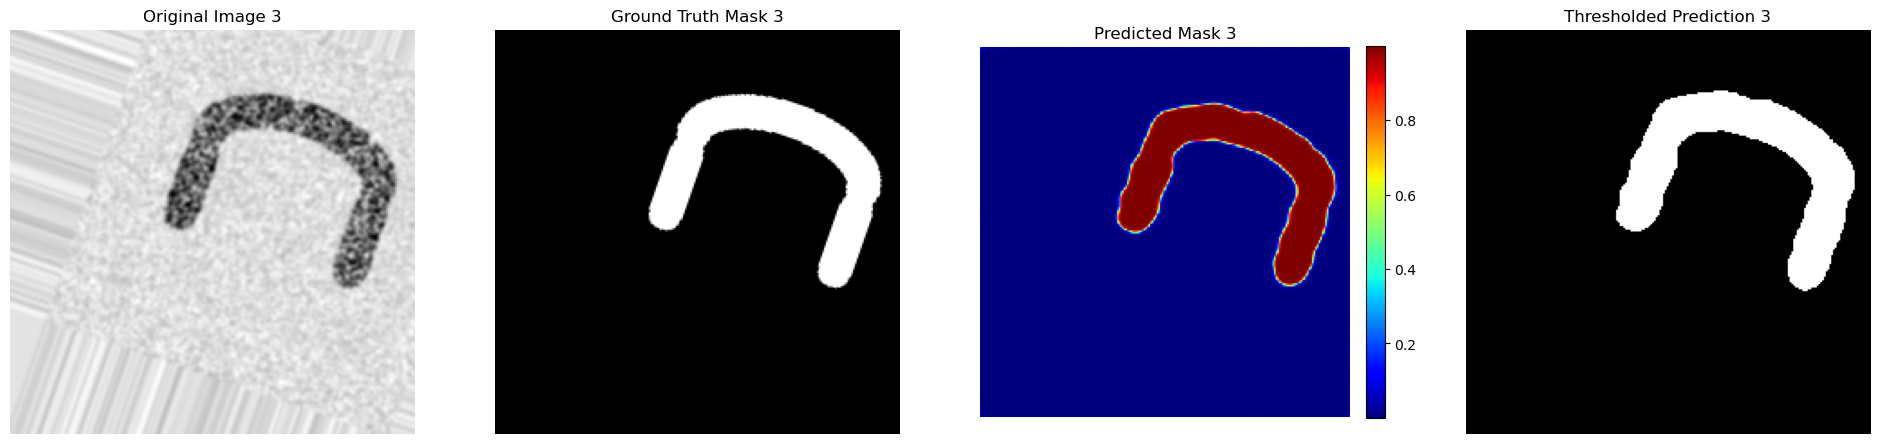

✅ Saved: /Users/rfalcao/Documents/FYP/ManualSegmentationAnns/results/Idealised_plots/augmented_comparison_4.png


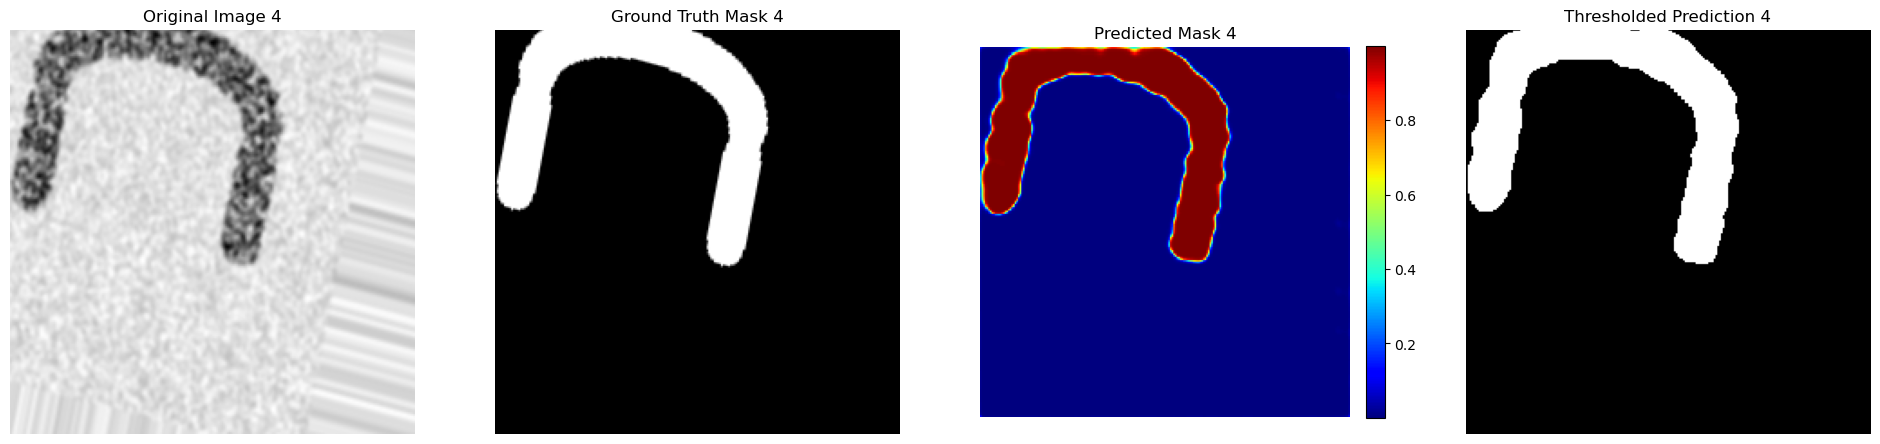

✅ Saved: /Users/rfalcao/Documents/FYP/ManualSegmentationAnns/results/Idealised_plots/augmented_comparison_5.png


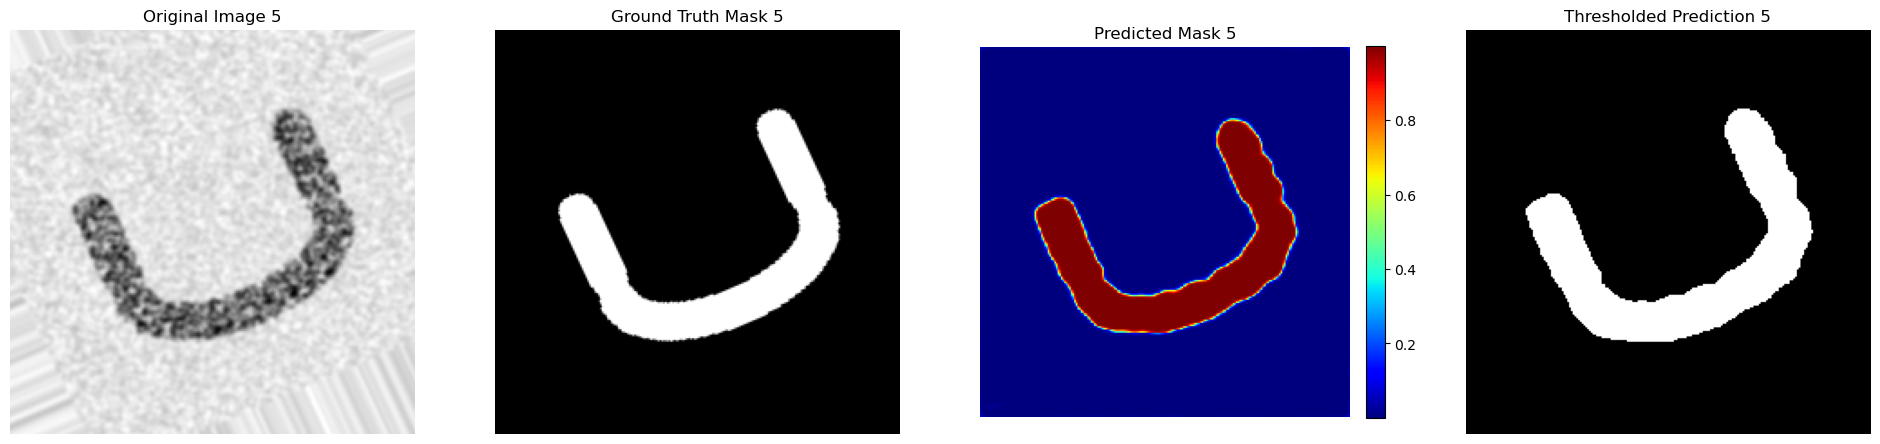

✅ Saved: /Users/rfalcao/Documents/FYP/ManualSegmentationAnns/results/Idealised_plots/augmented_comparison_6.png


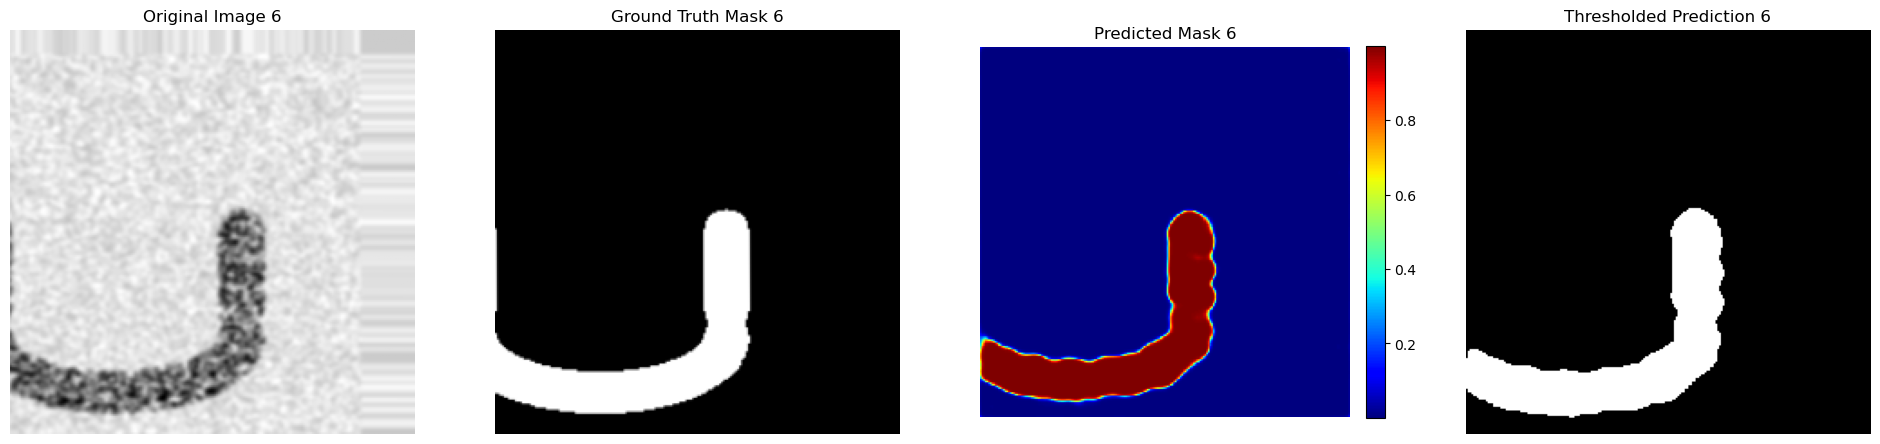

✅ Saved: /Users/rfalcao/Documents/FYP/ManualSegmentationAnns/results/Idealised_plots/augmented_comparison_7.png


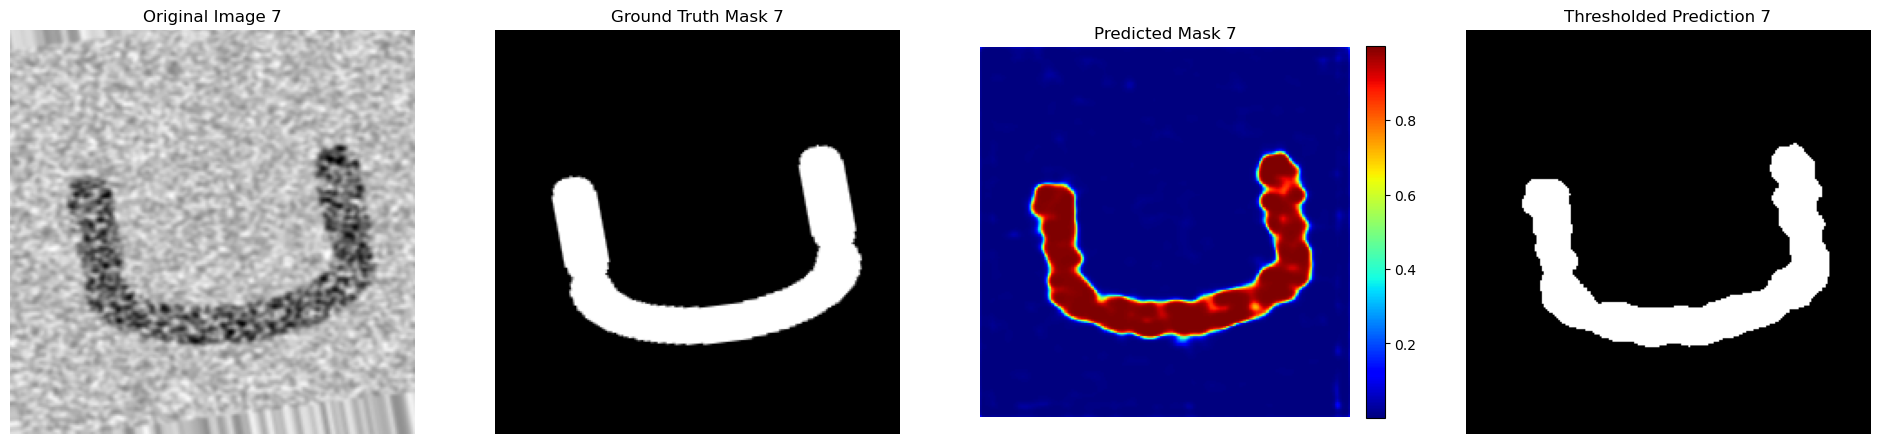

✅ Saved: /Users/rfalcao/Documents/FYP/ManualSegmentationAnns/results/Idealised_plots/augmented_comparison_8.png


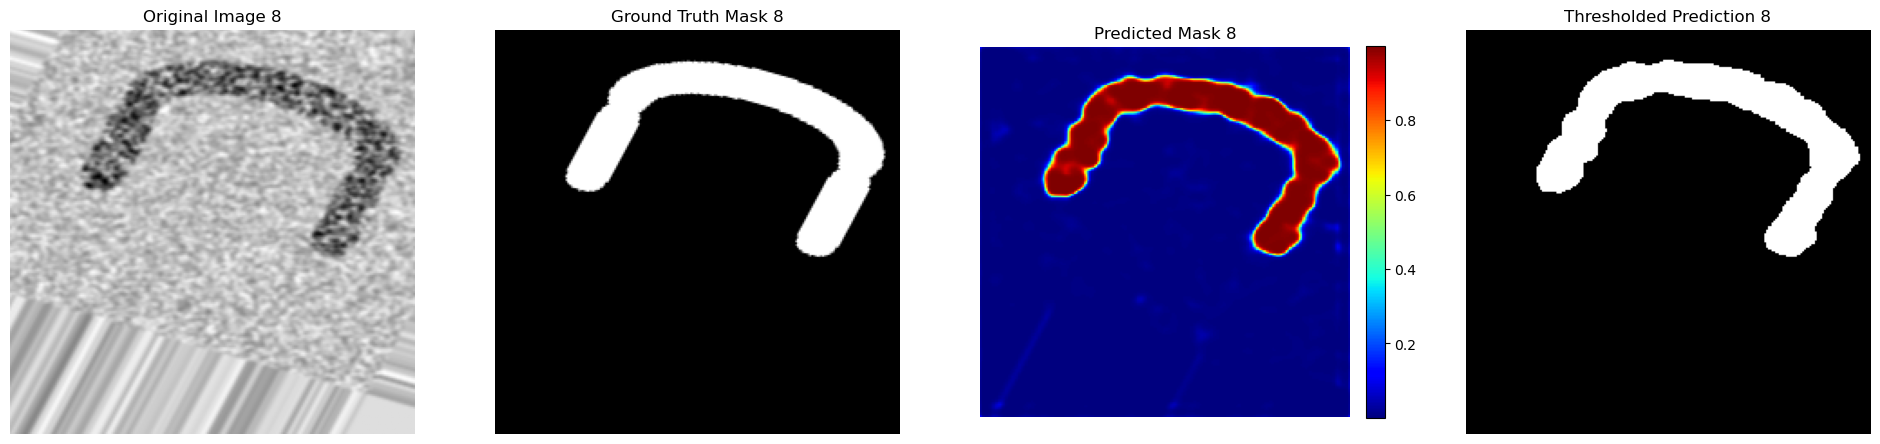

✅ Saved: /Users/rfalcao/Documents/FYP/ManualSegmentationAnns/results/Idealised_plots/augmented_comparison_9.png


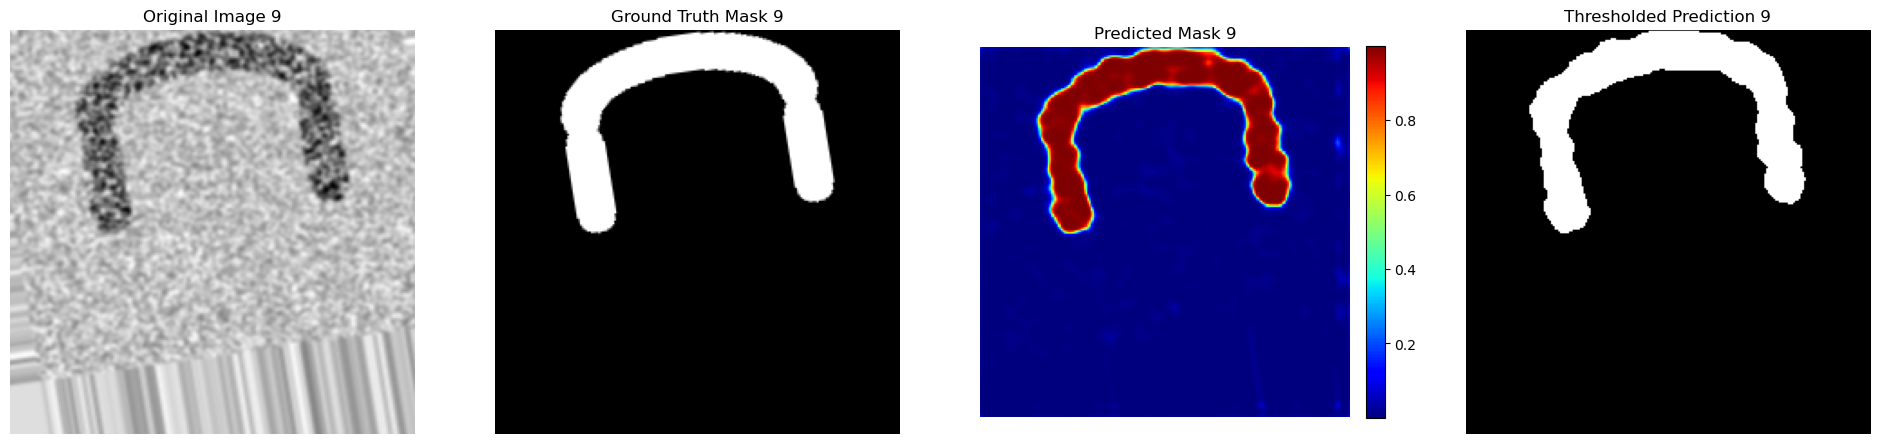

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Define augmentation parameters
test_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def augment_test_images(images, masks, num_augments=5):
    """
    Augment test images and masks, ensuring they are 3-channel before augmentation.

    Args:
        images (numpy array): Test images (grayscale).
        masks (numpy array): Corresponding test masks.
        num_augments (int): Number of augmented images per test sample.

    Returns:
        (numpy array, numpy array): Augmented images and masks.
    """
    augmented_images, augmented_masks = [], []

    for i in range(len(images)):
        img = images[i].squeeze()  # Ensure single-channel format
        mask = masks[i].squeeze()

        # ✅ Convert grayscale image to 3-channel format
        img_3c = cv2.merge([img, img, img])
        mask_3c = cv2.merge([mask, mask, mask])

        for _ in range(num_augments):
            seed = np.random.randint(10000)  # Same seed ensures identical transformation
            aug_img = test_datagen.random_transform(img_3c, seed=seed)
            aug_mask = test_datagen.random_transform(mask_3c, seed=seed)

            # ✅ Convert back to grayscale (take only one channel)
            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2GRAY)
            aug_mask = cv2.cvtColor(aug_mask, cv2.COLOR_BGR2GRAY)

            augmented_images.append(np.expand_dims(aug_img, axis=-1))  # Add back channel dimension
            augmented_masks.append(np.expand_dims(aug_mask, axis=-1))

    return np.array(augmented_images), np.array(augmented_masks)

def plot_comparison(image, true_mask, predicted_mask, threshold=0.5, index=None, save_dir="augmented_comparison_results"):
    """
    Display and save the original image, ground truth mask, predicted mask, 
    and thresholded binary mask side by side.

    Args:
        image (numpy array): Original grayscale image.
        true_mask (numpy array): Ground truth binary mask.
        predicted_mask (numpy array): Model-predicted probability mask.
        threshold (float): Threshold to binarize the predicted mask.
        index (int, optional): Image index for display title.
        save_dir (str): Directory where plots will be saved.
    """
    # Apply threshold to predicted mask
    binary_mask = (predicted_mask > threshold)  # Convert probabilities to binary

    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(24, 6))  # Create a wide figure

    # 🔹 Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original Image {index}" if index is not None else "Original Image")
    plt.axis("off")

    # 🔹 Ground Truth Mask
    plt.subplot(1, 4, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title(f"Ground Truth Mask {index}" if index is not None else "Ground Truth Mask")
    plt.axis("off")

    # 🔹 Predicted Mask (Probability Map)
    plt.subplot(1, 4, 3)
    mask_plot = plt.imshow(predicted_mask, cmap='jet')
    plt.colorbar(mask_plot, fraction=0.046, pad=0.04)  # ✅ Add probability legend
    plt.title(f"Predicted Mask {index}" if index is not None else "Predicted Mask")
    plt.axis("off")

    # 🔹 Thresholded Binary Mask
    plt.subplot(1, 4, 4)
    plt.imshow(binary_mask, cmap='gray')
    plt.title(f"Thresholded Prediction {index}" if index is not None else "Thresholded Prediction")
    plt.axis("off")

    # Save the figure
    save_path = os.path.join(save_dir, f"augmented_comparison_{index}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"✅ Saved: {save_path}")

    plt.show()
    plt.close()  # Close the plot to free memory

# ✅ Augment test images
X_test_augmented, y_test_augmented = augment_test_images(X_test, y_test, num_augments=3)

print(f"✅ Test set augmented: {len(X_test)} → {len(X_test_augmented)} images")

# ✅ Run predictions on augmented test set
test_pred_augmented = model.predict(X_test_augmented)

# ✅ Visualize and save augmented test images
for i in range(len(test_pred_augmented)):
    img = X_test_augmented[i].squeeze()  # Original image
    true_mask = y_test_augmented[i].squeeze()  # Ground truth mask
    predicted_mask = test_pred_augmented[i].squeeze()  # Model's predicted mask

    # Display and save the four images side by side
    plot_comparison(img, true_mask, predicted_mask, threshold=0.5, index=i+1, save_dir="/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/results/Idealised_plots")


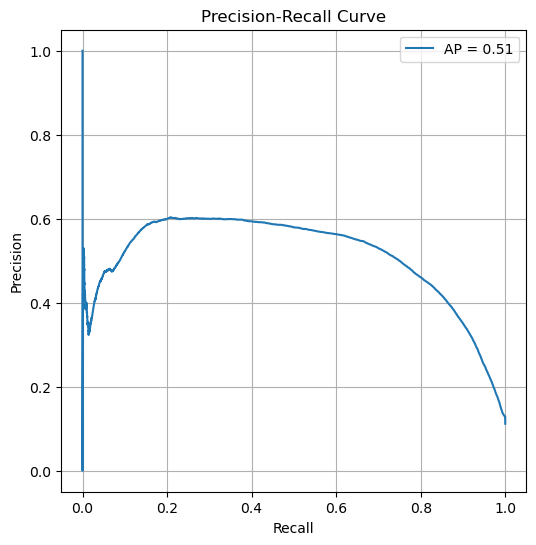

🔹 Average Precision Score: 0.5088


In [53]:
# ✅ Precision-Recall Curve
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

precision, recall, _ = precision_recall_curve(y_true_all, y_pred_all)
ap_score = average_precision_score(y_true_all, y_pred_all)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

print(f"🔹 Average Precision Score: {ap_score:.4f}")

The next section slides across a larger image, the window size makes a difference in masks produced

(1785, 2560)
